# Scope of this experiment is to perform the Explicit Regularization Significance experiment on CIFAR-10 dataset
<!--Model used Inception on CIFAR10  -->

 <!--cool list  -->
 ## Model used Inception on CIFAR10
<!-- Super cool list of things to do -->
### Accuracy vs Epochs for different Regularization Techniques
- [x] test(w/ aug, wd, dropout)
- [x] train(w/ aug, wd, dropout)
- [x] test(w/o aug, dropout)
- [x] train(w/o aug, dropout)
- [x] test(w/o aug, wd, dropout)
- [x] train(w/o aug, wd, dropout)



To replicate : 

Effects of Expilcit regularizers on generalization performance. aug is data augmentation,
wd is weight decay, BN is batch normalization. The shaded areas are the cumulative best test ac-
curacy, as an indicator of potential performance gain of early stopping. (a) early stopping could
potentially improve generalization when other regularizers are absent. (b) early stopping is not nec-
essarily helpful on CIFAR10, but batch normalization stablize the training process and improves
generalization.



Reference : 

* Data augmentation: augment the training set via domain-specific transformations. For
image data, commonly used transformations include random cropping, random perturba-
tion of brightness, saturation, hue and contrast.
* Weight decay: equivalent to a ` 2 regularizer on the weights; also equivalent to a hard
constrain of the weights to an Euclidean ball, with the radius decided by the amount of
weight decay.
* Dropout (Srivastava et al., 2014): mask out each element of a layer output randomly with
a given dropout probability. Only the Inception V3 for ImageNet uses dropout in our
experiments.






In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import time
from torchsummary import summary
from tqdm import tqdm
import tensorflow
import tensorflow as tf
from sklearn.metrics import accuracy_score
# import models from torchvision
from torchvision import models

In [2]:
def get_device():
  if torch.cuda.is_available():
      return torch.device('cuda')
  else:
      return torch.device('cpu')
device = get_device()
device

device(type='cuda')

In [21]:
# # Data loader

transform = transforms.Compose([transforms.ToTensor(),transforms.CenterCrop(32),transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

aug_transform = transforms.Compose([
    transforms.RandomCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.1, saturation=0.1, hue=0.1, contrast=0.1),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

batch_size = 32

In [4]:
aug_train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, transform=aug_transform, download=True)
train_dataset = torchvision.datasets.CIFAR10(root='./', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.CIFAR10(root='./', train=False, transform=transform, download=True)

100%|██████████| 170498071/170498071 [00:13<00:00, 12948413.00it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified
Files already downloaded and verified


In [22]:
train_loader = torch.utils.data.DataLoader(train_dataset , batch_size = batch_size , shuffle=True, num_workers=2)
test_loader =  torch.utils.data.DataLoader(test_dataset , batch_size = batch_size , shuffle=False, num_workers=2)
aug_train_loader = torch.utils.data.DataLoader(aug_train_dataset , batch_size = batch_size , shuffle=True, num_workers=2)

In [6]:
# conv module with or without dropout based on dropout_flag

class ConvModule(nn.Module):
    def __init__(self , dropout_flag , in_channels , out_channels , kernel_size , stride , padding):
        super(ConvModule , self).__init__()
        self.conv = nn.Conv2d(in_channels , out_channels , kernel_size , stride , padding)
        self.dropout_flag = dropout_flag
        if dropout_flag:
            self.dropout = nn.Dropout(p = 0.5)
        self.relu = nn.ReLU()    
    def forward(self , input):
        output = self.conv(input)
        if self.dropout_flag:
            output = self.dropout(output)
        output = self.relu(output)
        return output


class InceptionModule(nn.Module):
    def __init__(self , dropout_flag , in_channels , Ch1 , Ch3):
        super(InceptionModule , self).__init__()
        self.branch1 = ConvModule(dropout_flag , in_channels , Ch1 , kernel_size = 1 , stride = 1 , padding = 0)
        self.branch2 = ConvModule(dropout_flag , in_channels , Ch3 , kernel_size = 3 , stride = 1 , padding = 1)
    def forward(self , input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        return torch.cat([branch1 , branch2] , 1)


class DownSampleModule(nn.Module):
    def __init__(self , dropout_flag , in_channels , Ch3):
        super(DownSampleModule , self).__init__()
        self.branch1 = ConvModule(dropout_flag , in_channels , Ch3 , kernel_size = 3 , stride = 2 , padding = 0)
        self.branch2 = nn.MaxPool2d(3 , stride = 2)
    def forward(self , input):
        branch1 = self.branch1(input)
        branch2 = self.branch2(input)
        return torch.cat([branch1 , branch2] , 1)


class InceptionNet(nn.Module):
    def __init__(self , dropout_flag , classes = 10):
        super(InceptionNet , self).__init__()
        self.conv1 = ConvModule(dropout_flag , in_channels = 3 , out_channels = 96 , kernel_size = 3 , stride = 1 , padding = 0)
        self.inception1 = InceptionModule(dropout_flag , in_channels = 96 , Ch1 = 32 , Ch3 = 32)
        self.inception2 = InceptionModule(dropout_flag , in_channels = 64 , Ch1 = 32 , Ch3 = 48)
        self.downsample1 = DownSampleModule(dropout_flag , in_channels = 80 , Ch3 = 80)
        self.inception3 = InceptionModule(dropout_flag , in_channels = 160 , Ch1 = 112 , Ch3 = 48)
        self.inception4 = InceptionModule(dropout_flag , in_channels = 160 , Ch1 = 96 , Ch3 = 64)
        self.inception5 = InceptionModule(dropout_flag , in_channels = 160 , Ch1 = 80 , Ch3 = 80)
        self.inception6 = InceptionModule(dropout_flag , in_channels = 160 , Ch1 = 48 , Ch3 = 96)
        self.downsample2 = DownSampleModule(dropout_flag , in_channels = 144 , Ch3 = 96)
        self.inception7 = InceptionModule(dropout_flag , in_channels = 240 , Ch1 = 176 , Ch3 = 160)
        self.inception8 = InceptionModule(dropout_flag , in_channels = 336 , Ch1 = 176 , Ch3 = 160)
        self.mean_pool = nn.AdaptiveAvgPool2d((7 , 7))
        self.fc = nn.Linear(16464, classes)
    def forward(self , input):
        output = self.conv1(input)
        output = self.inception1(output)
        output = self.inception2(output)
        output = self.downsample1(output)
        output = self.inception3(output)
        output = self.inception4(output)
        output = self.inception5(output)
        output = self.inception6(output)
        output = self.downsample2(output)
        output = self.inception7(output)
        output = self.inception8(output)
        output = self.mean_pool(output)
        output = torch.flatten(output,1)
        output = self.fc(output)
        return output

In [23]:
def LabelCorruption(percentage,myloader):
    labels = myloader.dataset.targets[:]
    data = myloader.dataset.data
    num = int(len(labels)*percentage)
    idxes = []
    if percentage == 1:
        idxes = list(range(len(labels)))
    while len(idxes) < num:
        idx = np.random.randint(0,len(labels))
        if idx not in idxes:
            idxes.append(idx)
    for idx in idxes:
        randomLabel = np.random.randint(0,10)
        while randomLabel == labels[idx]:
            randomLabel = np.random.randint(0,10)
        labels[idx] = randomLabel
    corrupted_dataset = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform)
    corrupted_dataset.data = data
    corrupted_dataset.targets = labels
    corrupted_loader = torch.utils.data.DataLoader(dataset=corrupted_dataset, batch_size=batch_size, shuffle=True)
    return corrupted_loader

In [27]:
def get_accuracy(model,data_loader):
  model.eval()
  correct , total = 0 , 0
  for i, data in enumerate(data_loader, 0):
    images, labels = data[0].to(device), data[1].to(device)
    outputs = model(images)
    _, preds = torch.max(outputs, dim=1)
    total += labels.size(0)
    correct += (preds == labels).sum().item()
  return (correct / total)


def fit(epoch, model, train_loader, test_loader , weight_decay):

    model = model.cuda()

    optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)  
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 100, gamma=1.0)

    criterion = nn.CrossEntropyLoss().to(device)

    warmup_epochs = 2
    warmup_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.95)

    train_acc , test_acc = [] , []

    # warmup_o
    randomloader = LabelCorruption(0.5,train_loader)
    for epoch in range(warmup_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        for i, data in enumerate(randomloader , 0):
            inputs, labels = data
            inputs, labels = inputs.cuda(), labels.cuda()
            # print image shape
            # print(inputs.shape)
            total += labels.size(0)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            correct += predicted.eq(labels).sum().item()
            if i % 100 == 0:
                curr_train_acc , curr_test_acc = get_accuracy(model , train_loader) , get_accuracy(model , test_loader)
                train_acc.append(curr_train_acc)
                test_acc.append(curr_test_acc)
        warmup_scheduler.step()

    if weight_decay:
        optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9 , weight_decay = 0.95)  
    
    count = 0
        
    for epoch in range(epoch):  
        running_loss = 0.0

        for i, data in enumerate(train_loader, 0):
          
          inputs, labels = data[0].to(device), data[1].to(device)
          optimizer.zero_grad()
          outputs = model(inputs)
          loss = criterion(outputs, labels)
          loss.backward()
          optimizer.step()

          running_loss += loss.item()
          count += 1

          if count % 1000 == 0:
            curr_train_acc , curr_test_acc = get_accuracy(model , train_loader) , get_accuracy(model , test_loader)
            model.train()
            train_acc.append(curr_train_acc)
            test_acc.append(curr_test_acc)

        # print("Epoch {} | loss: {:.4f} | Train acc: {:.4f} | Val acc: {:.4f}".format(epoch + 1 , running_loss , curr_train_acc , curr_test_acc))
        scheduler.step()
    return model,train_acc,test_acc

In [8]:
model1 =  InceptionNet(dropout_flag = True)
model2 =  InceptionNet(dropout_flag = False)
model3 =  InceptionNet(dropout_flag = False)

In [29]:
# Experiment 1: Data Augmentation , Weight Decay , Dropout

AugWdv3model , AugWdtrainacc , AugWdtestacc = fit(100 , model1, aug_train_loader ,test_loader , weight_decay = True)

Files already downloaded and verified


In [30]:
# Experiment 2: No Data Augmentation , Weight Decay , No Dropout

noAugWdv3model , noAugWdtrainacc , noAugWdtestacc = fit(100 , model2 , train_loader , test_loader, weight_decay = True)

Files already downloaded and verified


In [28]:
# Experiment 3: No Data Augmentation , No Weight Decay , No Dropout

noAugnoWdv3model , noAugnoWdtrainacc , noAugnoWdtestacc = fit(100 , model3 , train_loader ,test_loader, weight_decay = False) 

Files already downloaded and verified


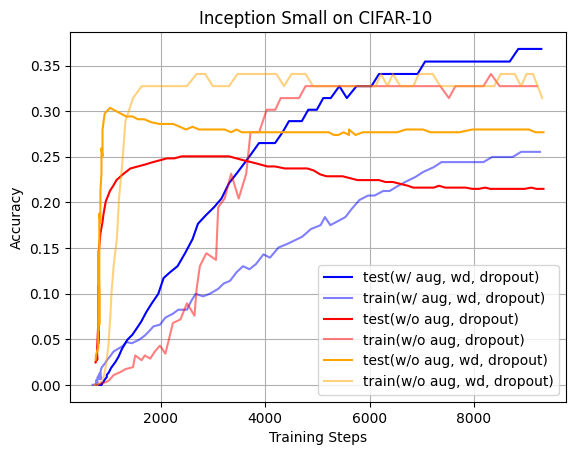

In [33]:
plt.plot(AugWdtestacc , label='test(w/ aug, wd, dropout)' , color = 'blue')
plt.plot(AugWdtrainacc , label='train(w/ aug, wd, dropout)' , alpha = 0.5 , color = 'blue')

plt.plot(noAugWdtestacc , label='test(w/o aug, dropout)' , color = 'red')
plt.plot(noAugWdtrainacc , label='train(w/o aug, dropout)' , alpha = 0.5 , color = 'red')

plt.plot(noAugnoWdtestacc , label='test(w/o aug, wd, dropout)' , color = 'orange')
plt.plot(noAugnoWdtrainacc , label='train(w/o aug, wd, dropout)' , alpha = 0.5 , color = 'orange')

plt.grid()
plt.xlabel('Training Steps')
plt.ylabel('Accuracy')
plt.title('Inception Small on CIFAR-10 ')
plt.legend()
plt.show()